# Table of Contents
* [Setup](#Setup)
	* [estimate cost](#estimate-cost)
	* [load dataset](#load-dataset)
* [Submitting HITs](#Submitting-HITs)
* [Retrieve results](#Retrieve-results)
* [Interact with workers](#Interact-with-workers)
* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2


import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)


import re
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
import random
from tqdm import tqdm

from IPython.core.display import HTML

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo


from amt_utils.mturk import MTurk
from amt_utils.mturk import pickle_this, unpickle_this

# Setup - Stage 2

## estimate cost

In [576]:
cost_per_hit = 0.04
n_turkers_per_hit = 3
n_hits_per_video = 1

simpler_cost_per_hit = 0.02

n_videos_low = 200
n_videos_high = 52313
# n_videos_high = 20000

low = cost_per_hit * n_turkers_per_hit * n_videos_low * n_hits_per_video
high = cost_per_hit * n_turkers_per_hit * n_videos_high * n_hits_per_video
subtask = simpler_cost_per_hit* n_turkers_per_hit * n_videos_high * n_hits_per_video * 1.38

stage_2 = 0.04 * n_turkers_per_hit * n_videos_high

stage_3 = 0.04 * n_turkers_per_hit * n_videos_high * 0.10 +  simpler_cost_per_hit * n_turkers_per_hit * n_videos_high

stage_4 = 0.05 * 1 * n_videos_high

stage_1 = high + subtask

print(str(low) + ' - $' + str(high))
print(subtask)
print(high + subtask)
print(stage_1, stage_2, stage_3, stage_4)
print(stage_1 + stage_2 + stage_3 + stage_4)

24.0 - $6277.56
4331.5164
10609.0764
(10609.076399999998, 6277.5599999999995, 3766.5359999999996, 2615.65)
23268.8224


## load dataset

In [75]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/subtask_frames/'

s3_base_path_stills = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

s3_base_path_gifs = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs/s_03_e_22/'

s3_base_paths = {
    'subtask': s3_base_path,
    'stills': s3_base_path_stills,
    'gifs': s3_base_path_gifs
}

data_file_path = '../../build_dataset/stage1_single_char_ds_v1.pkl'

ds_stage_1 = unpickle_this(data_file_path)
all_stills_to_annotate = []

# for clip in ds_skeleton:
#     for still in clip['keyFrames']:
#         all_stills_to_annotate.append(still)
# len(all_stills_to_annotate)

In [3]:
len(ds_stage_1)

8193

In [469]:
all_prod_aids = [aid[:-7] for aid in all_stills_to_annotate]

In [473]:
# with open('complete_clips.txt', 'r') as f:
#     clips_completed_raw = f.read()

# clips_completed = set(clips_completed_raw.split())

# Submitting HITs

In [58]:
from amt_utils.flintstones import prepare_stage_2_hit
from amt_utils.flintstones import prepare_stage_2b_hit

from amt_utils.flintstones import generate_simpler_task_page
from amt_utils.flintstones import write_task_page

from amt_utils.mturk import expected_cost

In [4]:
turk_account = mturk_ai2
rw_host='mechanicalturk.amazonaws.com'
# amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key, host=rw_host)
amt_con = MTurk(turk_account.access_key, turk_account.access_secret_key)
amt_con.get_account_balance()

$10,000.00

In [101]:
static_params = {
    'title': "Describe a character in an animation frame",
    'description': "Describe the pose and location of a character from drop down menus and a text entry box",
    'keywords': ['animation', 'image', 'image annotation'],
    'frame_height': 1000,
    'amount': 0.01,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3,
}

In [180]:
# settings = ['kitchen', 'bedroom', 'living room', 'dining room', 'quarry', 'garden', 'in car']
poses = ['Select Pose', 'standing', 'sitting', 'walking', 'laying', 'leaning', 'riding', 'crouching']
position_prepositions = ['Select Position', 'next to', 'in front of', 'on', 'in', 'to the left of', 'to the right of', 'behind', 'under']

In [78]:
current_batch = ds_stage_1[5:6]

In [130]:
s3_batch = [vid for vid in ds_stage_1 if 's_03_e_22' in vid['globalID']]

In [182]:
# build_hit_group = [prepare_stage_2_hit(s3_base_paths, vid_ann, poses, position_prepositions, static_params) for vid_ann in tqdm(current_batch)]
# write_task_page(build_hit_group[0]['html'][0])

In [184]:
expected_cost(build_hit_group, static_params, amt_con)

0.03

In [198]:
build_hit_group = []
for vid_ann in tqdm(current_batch):
    build_hit_group.extend(prepare_stage_2_hit(s3_base_paths, vid_ann, poses, position_prepositions, static_params))
write_task_page(build_hit_group[0]['html'])



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 104.20it/s]

In [186]:
# build_hit_group = [prepare_stage_2_hit(s3_base_paths, vid_ann, poses, position_prepositions, static_params) for ]
# write_task_page(build_hit_group[0]['html'][0])

**Procedure**

1. assure interface template is working

2. build and load ds skeleton for the sample to be submitted

3. make sure to sync images to s3

4. double check static params and host

5. build and submit

In [187]:
hit_group = [amt_con.create_html_hit(single_hit) for single_hit in tqdm(build_hit_group)]



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.21it/s]



last frame 6456

# Retrieve results

In [599]:
from amt_utils.flintstones import get_assignments
from amt_utils.flintstones import filter_hits_by_date
from amt_utils.flintstones import filter_hits_by_completion
from amt_utils.flintstones import filter_hits_by_status
from amt_utils.flintstones import get_completed_hits
from amt_utils.flintstones import get_assignments
from amt_utils.mturk import pickle_this

In [ ]:
import datetime
import dateutil.parser as dt_parse

In [535]:
all_hits = amt_con.get_all_hits()

In [600]:
start_date = (2017, 8, 11)
end_date = (2017, 8, 12)
recent_hits = filter_hits_by_date(all_hits, start_date, end_date)
# recent_hits = filter_hits_by_status(recent_hits)

In [601]:
len(recent_hits)

1632

In [549]:
# prod_results_1_4 = recent_hits

In [ ]:
batch_8 = get_assignments(amt_con.connection, recent_hits)

In [ ]:
len(all_hits)

In [ ]:
th1 = all_hits[0]

In [ ]:
th1.Title

In [ ]:
subtask_hits = 

In [ ]:
len(recent_hits)

In [544]:
creation_times = pd.Series([dt_parse.parse(hit.CreationTime) for hit in recent_hits])

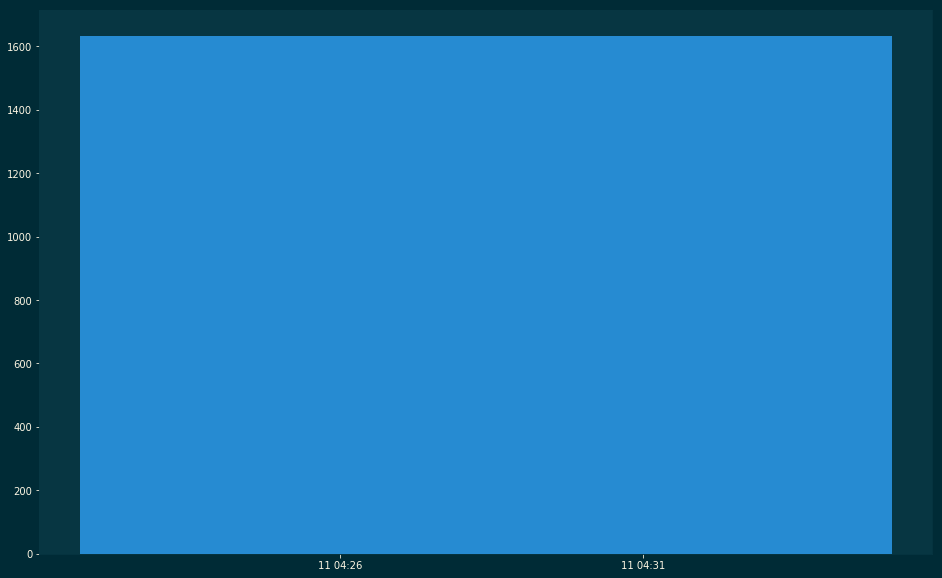

In [548]:
_ = creation_times.hist(bins = 1)

In [554]:
len(recent_hits)

1632

In [559]:
results = get_assignments(amt_con.connection, tqdm(prod_results_1_4))

100%|██████████| 20000/20000 [35:50<00:00,  8.45it/s] 


In [560]:
len(results)

20000

In [562]:
results

TypeError: unhashable type

In [561]:
pickle_this(results, 'prod_batch_1_4.pkl')

In [552]:
batch_8 = unpickle_this('./pickeled_results/turker_batch_8.pkl')

In [553]:
len(batch_8)

1632

## check results

In [506]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [513]:
assignments =[]
for assignment_triple in list(results.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [514]:
characters_present

[{'characters': {u'judge'},
  'h_id': u'31S7M7DAGHQCUSQF0AU15OEW4LOLTV',
  'still_id': u's_06_e_04_shot_014628_014702_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hoppy'},
  'h_id': u'3FI30CQHVLJUFLTRDKXEGBQD8LQ6BD',
  'still_id': u's_05_e_22_shot_037596_037670_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'wilma'},
  'h_id': u'35XW21VSVHEBFSD0BAPBVJIA22ALS6',
  'still_id': u's_02_e_29_shot_005091_005165_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'fred', u'wilma'},
  'h_id': u'3W3RSPVVGTRRU5540FKBAK0YNZVLUM',
  'still_id': u's_04_e_16_shot_018813_018887_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'door', u'fred'},
  'h_id': u'3HUR21WDDVP3B86YOZKOOZ1YQY6YXD',
  'still_id': u's_01_e_24_shot_033229_033303_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'hat'},
  'h_id': u'3SMIWMMK62575ZH34TRDJVHEL8PUWI',
  'still_id': u's_02_e_08_shot_019539_019613_40.png',
  'w_id': u'AO235WMFCB1D9'},
 {'characters': {u'barney', u'roof'},


# Interact with workers

## reject assignments and ban workers

In [37]:
def ban_bad_workers(mturk_connection, worker_ids):
    for worker in worker_ids:
        reason_for_block = """
        Your HITs contained many frames with characters, but they were marked 'empty frame'
        """
        print('blocking ' + str(worker))
        mturk_connection.block_worker(worker, reason_for_block)

In [38]:
workers_to_ban = unpickle_this('workers_to_ban_prod_1_4.pkl')

In [39]:
workers_to_ban

{u'A13ISH3PAGHO0A',
 u'A15DOG6AXQ7LGY',
 u'A1CF1W8CP0DHB0',
 u'A1IOMFFEKCWOIT',
 u'A1QP6651C4Q8NS',
 u'A1RULXRXR2XF6M',
 u'A273GB71FE8RIV',
 u'A2CXEAMWU2SFV3',
 u'A2L97S8Z5FZK5N',
 u'A2NJTYYY37DNO',
 u'A2PU4YNWITAQVL',
 u'A2X7BE2FSPUKCK',
 u'A3R6KO03P9QLNO',
 u'A3UPV16IECELHV',
 u'A9ALF1SODWQE5'}

In [40]:
ban_bad_workers(amt_con.connection, list(workers_to_ban))

blocking A2PU4YNWITAQVL
blocking A273GB71FE8RIV
blocking A3R6KO03P9QLNO
blocking A2X7BE2FSPUKCK
blocking A1QP6651C4Q8NS
blocking A2CXEAMWU2SFV3
blocking A2NJTYYY37DNO
blocking A1CF1W8CP0DHB0
blocking A3UPV16IECELHV
blocking A2L97S8Z5FZK5N
blocking A1IOMFFEKCWOIT
blocking A15DOG6AXQ7LGY
blocking A9ALF1SODWQE5
blocking A1RULXRXR2XF6M
blocking A13ISH3PAGHO0A


In [46]:
to_reject = unpickle_this('assignments_to_reject_prod_1_4.pkl')

In [48]:
len(to_reject) * 0.04

378.16

In [43]:
def reject_assignments(mturk_connection, assignments_to_reject):
    feedback_message = """
    Your HITs contained many frames with characters, but they were marked 'empty frame'
    """
    reject_count = len(assignments_to_reject)
    for assignment_id in tqdm(assignments_to_reject):
        try:
            mturk_connection.reject_assignment(assignment_id, feedback_message)
        except boto.mturk.connection.MTurkRequestError:
            print('assignment ' + str(assignment_id) + ' already accepted or rejected')

    return reject_count

In [45]:
# reject_assignments(amt_con.connection, list(to_reject))

## pay bonuses

In [ ]:
subject = "More  HITs are available"
message = """
Hello, 

"""

In [ ]:
# _ = mturk.notify_workers(good_workers[:20], subject, message)

In [455]:
bonuses = unpickle_this('bonuses_to_pay_3.pkl')

In [458]:
def pay_bonuses(bonuses_to_pay):
    total_payed = 0
    bonus_reason_template = 'For Flinstones character labels written.'
    for aid, vals in tqdm(bonuses_to_pay.items()):
        n_chars = vals['count']
        wid = vals['worker_id']
        bonus_ammount = boto.mturk.price.Price(0.01 * n_chars)
        total_payed += bonus_ammount.amount
        bonus_reason = bonus_reason_template
        amt_con.connection.grant_bonus(wid, aid, bonus_ammount, bonus_reason)
    return total_payed

In [460]:
# pay_bonuses(bonuses)

# Accepting and deleting HITs

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [8]:
accept_results = unpickle_this('pickeled_results/prod_batch_1_4.pkl')

In [9]:
len(accept_results)

20000

In [10]:
assignments =[]
for assignment_triple in list(accept_results.values()):
    assignments.extend(assignment_triple)

len(assignments)

59836

In [35]:
to_reject = unpickle_this('./assignments_to_reject_prod_1_4.pkl')

In [36]:
len(to_reject)

9454

In [12]:
assignments_to_accept = [asgmt for asgmt in assignments if asgmt.AssignmentId not in to_reject]

In [13]:
len(assignments_to_accept)

59836

In [22]:
e_count = 0
for assignment in tqdm(assignments_to_accept):
    try:
        amt_con.approve_assignment(assignment)
    except boto.mturk.connection.MTurkRequestError as e:
        e_count += 1

100%|██████████| 59836/59836 [2:27:34<00:00,  4.99it/s]  


In [23]:
e_count

41804

In [2]:
41772

41772

In [ ]:
print(e_count)

In [ ]:
# _ = [amt_con.disable_hit(hit) for hit in hits_today]

In [ ]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [88]:
amt_con.get_account_balance()

$10,000.00

In [179]:
amt_con.delete_all_hits()